<a href="https://colab.research.google.com/github/BlackPuma075/Advanced_Lab_2025/blob/main/Final%20Project/PS_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Final project - Advanced Lab 2025**

June 2025

*Diego González Sandoval (UG)*

In [14]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from google.colab import files
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_squared_error

In [2]:
#Boltzmann solver CLASS installation

!apt-get install -y gfortran
!git clone https://github.com/lesgourg/class_public.git
%cd class_public
!make
%cd python
!python3 setup.py install

from classy import Class

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gfortran is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'class_public'...
remote: Enumerating objects: 31195, done.
remote: Total 31195 (delta 0), reused 0 (delta 0), pack-reused 31195 (from 2)
Receiving objects: 100% (31195/31195), 772.26 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (21623/21623), done.
/content/class_public
if ! [ -e /content/class_public/build ]; then mkdir /content/class_public/build ; mkdir /content/class_public/build/lib; fi;
touch build/.base
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__='"/content/class_public"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -I../external/Halofit -I../external/HMcode -c ../tools/growTable.c -o growTable.o
cd /content/class_public/build;gcc -O3 -pthread  -g -fPIC -D__CLASSDIR__=

#**$\Omega_m$ free only part**

In [3]:
#100 spectra catalog 1 free parameter (Omm)

#Fixed values
h = 0.67
omega_b = 0.022
A_s = 2.1e-9
n_s = 0.96
tau = 0.06
z = 0.0
ks = np.logspace(-3, 1, 100)  #100 between 0.001 and 10 h/Mpc

#Omm range
Omega_m_vals = np.linspace(0.2, 0.4, 100)  #Between 0.2 and 0.4

#List to save the spectra
spectra = []

for Omega_m in Omega_m_vals:

    omega_cdm = Omega_m * h**2 - omega_b

    #Cosmology
    cosmo = Class()
    cosmo.set({
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau,
        'output': 'mPk',
        'P_k_max_1/Mpc': 10.0
    })

    #Compute spectrum
    cosmo.compute()
    Pk = [cosmo.pk(k, z) for k in ks]
    spectra.append(Pk)

    cosmo.struct_cleanup()
    cosmo.empty()

#'Spectra' is now the 100 spectra catalog

In [4]:
#Data preprocessing

Pks = np.array(spectra) #NN inputs
Omm_labels = Omega_m_vals #NN targets

X_train, X_test, y_train, y_test = train_test_split(Pks, Omm_labels, test_size=0.2, shuffle=True, random_state=1) #Random state to get the same shuffle every time

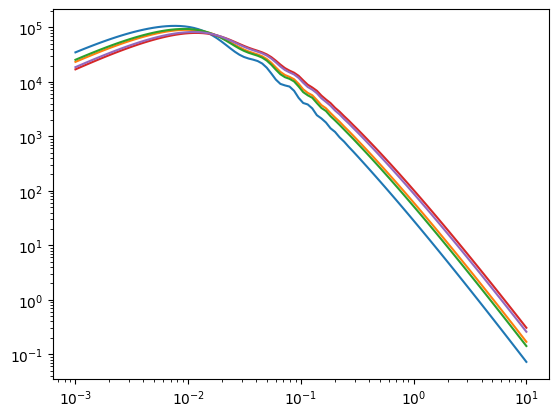

In [5]:
#Variation in Pk's as Omm varies (Shuffle works)
plt.loglog(ks, X_train[0])
plt.loglog(ks, X_train[5])
plt.loglog(ks, X_train[7])
plt.loglog(ks,X_train[10])
plt.loglog(ks, X_train[50])

In [11]:
#Normalization

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1))

In [19]:
#Best NN model

tf.random.set_seed(1234)
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(1, activation='linear', kernel_initializer='he_uniform')
])

model.summary()
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['mse']
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,601 (123.44 KB)

 Trainable params: 31,001 (121.10 KB)

 Non-trainable params: 600 (2.34 KB)

In [20]:
#Run fits and prediction test

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[reduce_lr, early_stop]
)

eval_metrics = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MSE: {eval_metrics[0]:.5e}")

y_hat_cont = model.predict(X_test_scaled)
for i in range(5):
    print(f"Real: {y_test_scaled[i]}, Pred: {y_hat_cont[i]}")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 2.2470 - mse: 2.2470 - val_loss: 0.0234 - val_mse: 0.0234 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.6923 - mse: 0.6923 - val_loss: 0.8141 - val_mse: 0.8141 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.6358 - mse: 0.6358 - val_loss: 1.1543 - val_mse: 1.1543 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5212 - mse: 0.5212 - val_loss: 0.9654 - val_mse: 0.9654 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6595 - mse: 0.6595 - val_loss: 0.5920 - val_mse: 0.5920 - learning_rate: 0.0010
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.3813 - mse: 0.3813
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4222 - mse: 0.4222 - val_loss: 0.3594 - val_mse: 0.3594 - learning_rate: 0.0010
Epoch 7/20
3/3 ━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

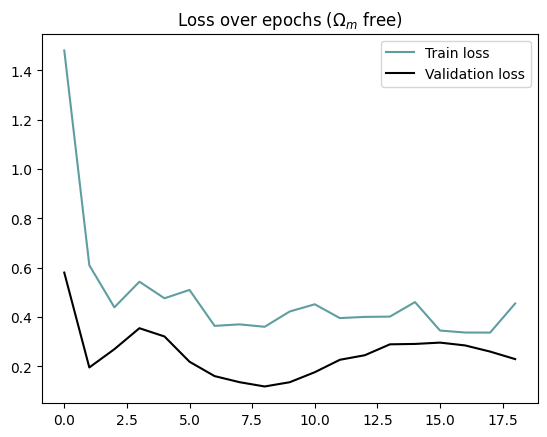

In [48]:
#Loss plot

plt.plot(history.history['loss'], label='Train loss', color ='cadetblue')
plt.plot(history.history['val_mse'], label='Validation loss', color = 'black')
plt.legend()
plt.title('Loss over epochs ($\Omega_m$ free)')
plt.savefig('model10_loss')
files.download("model10_loss.png")
plt.show()

In [22]:
#Re-Re Normalizarion (i.e. non-normalized data for the MSE calculation)

y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_real = scaler_y.inverse_transform(y_hat_cont)
from sklearn.metrics import mean_squared_error

mse_real = mean_squared_error(y_test_real, y_pred_real)
print(f"Descaled MSE: {mse_real}")
error = np.sqrt(mse_real)
print(f'Error: {error}')

Descaled MSE: 8.456011812372406e-05
Error: 0.009195657568859558


#**$\Omega_m$+$n_s$ free part**

In [23]:
#Fixed values
h = 0.67
omega_b = 0.022
A_s = 2.1e-9
#n_s = 0.96 #n_s free here
tau = 0.06
z = 0.0
ks = np.logspace(-3, 1, 100)

#Omm & ns ranges
Omega_m_vals = np.linspace(0.2, 0.4, 100)
ns_vals = np.linspace(0.95, 0.97,100)

spectra = []

for Omega_m in Omega_m_vals:

    omega_cdm = Omega_m * h**2 - omega_b

    for n_s in ns_vals: #Now we make the loop over n_s too

      #Cosmology
      cosmo = Class()
      cosmo.set({
          'h': h,
          'omega_b': omega_b,
          'omega_cdm': omega_cdm,
          'A_s': A_s,
          'n_s': n_s,
          'tau_reio': tau,
          'output': 'mPk',
          'P_k_max_1/Mpc': 10.0
      })


    cosmo.compute()
    Pk = [cosmo.pk(k, z) for k in ks]
    spectra.append(Pk)

    cosmo.struct_cleanup()
    cosmo.empty()

In [24]:
#Data preprocessing

Pks = np.array(spectra) #NN inputs
Labels = np.array([Omega_m_vals,ns_vals]).T #NN targets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Pks, Labels, test_size=0.2, shuffle=True, random_state=1) #Random state to get the same shuffle every time

X_train.shape, X_test.shape, y_train.shape, y_test.shape #Data shapes are already (nfeatures, nsamples)

((80, 100), (20, 100), (80, 2), (20, 2))

In [25]:
#Normalization

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled   = scaler_X.transform(X_test)

scaler_y = StandardScaler().fit(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled   = scaler_y.transform(y_test)

In [44]:
#Best NN model

tf.random.set_seed(1234)
model = Sequential([
    tf.keras.Input(shape=(X_train_scaled.shape[1],)),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(100, activation=None, kernel_initializer='he_uniform'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.1),

    Dense(2, activation='linear', kernel_initializer='he_uniform')
])

model.summary()
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer='adam',
    metrics=['mse']
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,702 (123.84 KB)

 Trainable params: 31,102 (121.49 KB)

 Non-trainable params: 600 (2.34 KB)

In [45]:
#Run fits & prediction test

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[reduce_lr, early_stop]
)

eval_metrics = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MSE: {eval_metrics[0]:.5e}")

y_hat_cont = model.predict(X_test_scaled)
for i in range(5):
    print(f"Real: {y_test_scaled[i]}, Pred: {y_hat_cont[i]}")

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - loss: 1.4931 - mse: 1.4931 - val_loss: 0.5803 - val_mse: 0.5803 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.6457 - mse: 0.6457 - val_loss: 0.1955 - val_mse: 0.1955 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4658 - mse: 0.4658 - val_loss: 0.2696 - val_mse: 0.2696 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5376 - mse: 0.5376 - val_loss: 0.3547 - val_mse: 0.3547 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5191 - mse: 0.5191 - val_loss: 0.3212 - val_mse: 0.3212 - learning_rate: 0.0010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5327 - mse: 0.5327 - val_loss: 0.2188 - val_mse: 0.2188 - learning_rate: 0.0010
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3851 - mse: 0.3851 - val_loss: 0.1605 - val_mse: 0.1605 - learning_rate: 0.0010
Epoch 8/20
3/3 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Real: [1.08902178 1.08902178], Pred: [1.3863441 1.5296859]
Real: [1.22435652 1.22435652], Pred: [1.5161313 1.8388052]
Real: [-0.50116148 -0.50116148], Pred: [-0.8274766 -0.9136844]
Real: [1.12285547 1.12285547], Pred: [1.4204105 1.6066358]
Real: [1.5288597 1.5288597], Pred: [1.671042  2.5619006]


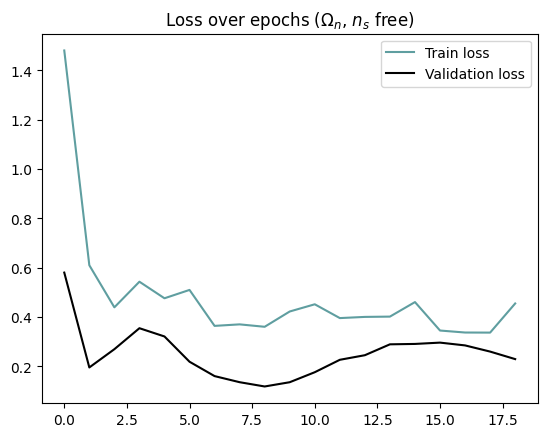

In [46]:
#Loss func. plot

plt.plot(history.history['loss'], label='Train loss', color ='cadetblue')
plt.plot(history.history['val_mse'], label='Validation loss', color = 'black')
plt.legend()
plt.title('Loss over epochs ($\Omega_n$, $n_s$ free)')
plt.show()

In [47]:
#Re-Re Normalizarion (i.e. non-normalized data for the MSE calculation)

y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_real = scaler_y.inverse_transform(y_hat_cont)
from sklearn.metrics import mean_squared_error

mse_real = mean_squared_error(y_test_real, y_pred_real)
print(f"Descaled MSE: {mse_real}")
error = np.sqrt(mse_real)
print(f'Error: {error}')

Descaled MSE: 0.00015650524896517598
Error: 0.012510205792279197
